# **Neuropolis: Building an artificial intelligence system for human brain activity prediction (EEG, fMRI)**

#### Version: 10th March 2024

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through nine Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Linear Regression*

***04: KNN, Decision Trees, Random Forests, SVM***

*05: Neural Networks*

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

*08: Transformers*

*09: Human Brain Predictability Map*

==============================================================================================

### Notebook 04

# **KNN, Decision Trees, Random Forests, SVM**

## **1. Linear Regression, Ridge Regression, Lasso Regression**

- **Models**: We train a series of linear regression models, using the normalized bandpowers and the selected sequence length of 5 scans. Our objective is to minimize the regression Mean Absolute Error (MAE). 

- **Strategies**: In the Predictor Brains strategy, we use the eegfmriNF condition as the train set, and the eegNF and fmriNF conditions as the test set, individually for each subject. In the Predictor Groups strategy, we use all the conditions of nine subjects as the train set, and all the conditions of the remaining tenth subject as the test set, and we repeat this process ten times in order to make predictions for all subjects. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import warnings

In [2]:
# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis_preprocessed_data/'

# Define the results path. 
results_path = '../neuropolis_results/'

In [3]:
# Load the features, the targets, and the baseline. 
with open(preprocessed_data_path + 'features/dict_features_bandpowers_normalized.p', 'rb') as file:
    dict_features_bandpowers = pickle.load(file)
with open(preprocessed_data_path + 'targets/dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)
with open(preprocessed_data_path + 'baseline/dict_baseline.p', 'rb') as file:
    dict_baseline_original = pickle.load(file)

In [4]:
# Define the list of subjects and define an example subject. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subject = subjects[0]

# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())

# Select a sequence length. 
selected_sequence_length = 5

# Retrieve the total number of scans. 
nb_scans_total = dict_targets[subject]['eegfmriNF']['pgACC'].shape[0]

In [5]:
# Define the dictionaries and the summary DataFrame for storing the features, targets, and baseline. 
dict_features_basis = dict()
dict_features_sequence = dict()
dict_targets_basis = dict()
dict_targets_sequence = dict()
dict_baseline_basis = dict()
dict_baseline_sequence = dict()
df_summary_global = pd.DataFrame()

# Iterate through all subjects. 
for subject in subjects:
        
    # Define the subject dictionaries. 
    dict_features_basis[subject] = dict()
    dict_features_sequence[subject] = dict()
    dict_targets_basis[subject] = dict()
    dict_targets_sequence[subject] = dict()
    dict_baseline_basis[subject] = dict()
    dict_baseline_sequence[subject] = dict()

    # Iterate through all conditions. 
    for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

        # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
        if subject == 'sub-xp102' and condition == 'eegNF':
            continue
            
        # Define the general features array by stacking all the EEG channels. 
        X_basis = np.vstack(dict_features_bandpowers[subject][condition]).transpose()

        # Define the general targets array. 
        Y_basis = np.zeros((nb_scans_total, len(targets)))
        for target_index in range(len(targets)):
            Y_basis[:, target_index] = dict_targets[subject][condition][targets[target_index]]

        # Define the general baseline array. 
        Baseline_basis = np.zeros((nb_scans_total, len(targets)))
        for target_index in range(len(targets)):
            Baseline_basis[:, target_index] = dict_baseline_original[subject][condition][targets[target_index]]

        # Define the particular features array. 
        X_sequence = np.zeros((nb_scans_total - selected_sequence_length, X_basis.shape[1] * (selected_sequence_length + 1)))
        for scan in range(nb_scans_total - selected_sequence_length):
            X_sequence[scan, :] = X_basis[scan:(scan + selected_sequence_length + 1), :].ravel()

        # Define the particular targets array. 
        Y_sequence = Y_basis[selected_sequence_length:, :]

        # Define the particular baseline array. 
        Baseline_sequence = Baseline_basis[selected_sequence_length:, :]

        # Store the features, targets and baseline in the dictionaries. 
        dict_features_basis[subject][condition] = X_basis
        dict_features_sequence[subject][condition] = X_sequence
        dict_targets_basis[subject][condition] = Y_basis
        dict_targets_sequence[subject][condition] = Y_sequence
        dict_baseline_basis[subject][condition] = Baseline_basis
        dict_baseline_sequence[subject][condition] = Baseline_sequence

        # Store the shapes of the arrays in the DataFrame. 
        df_summary_global.loc[subject + '/' + condition, 'subject'] = subject
        df_summary_global.loc[subject + '/' + condition, 'condition'] = condition
        df_summary_global.loc[subject + '/' + condition, 'X_basis.shape'] = str(X_basis.shape)
        df_summary_global.loc[subject + '/' + condition, 'X_sequence.shape'] = str(X_sequence.shape)
        df_summary_global.loc[subject + '/' + condition, 'Y_basis.shape'] = str(Y_basis.shape)
        df_summary_global.loc[subject + '/' + condition, 'Y_sequence.shape'] = str(Y_sequence.shape)
        df_summary_global.loc[subject + '/' + condition, 'Baseline_basis.shape'] = str(Baseline_basis.shape)
        df_summary_global.loc[subject + '/' + condition, 'Baseline_sequence.shape'] = str(Baseline_sequence.shape)

# Change the indexes of the DataFrame. 
df_summary_global = df_summary_global.set_index(['subject', 'condition'])

In [6]:
# Display the summary DataFrame. 
df_summary_global

X_basis.shape X_sequence.shape Y_basis.shape  \
subject   condition                                                
sub-xp101 eegNF        (200, 378)      (195, 2268)     (200, 17)   
          fmriNF       (200, 378)      (195, 2268)     (200, 17)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 17)   
sub-xp102 fmriNF       (200, 378)      (195, 2268)     (200, 17)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 17)   
sub-xp103 eegNF        (200, 378)      (195, 2268)     (200, 17)   
          fmriNF       (200, 378)      (195, 2268)     (200, 17)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 17)   
sub-xp104 eegNF        (200, 378)      (195, 2268)     (200, 17)   
          fmriNF       (200, 378)      (195, 2268)     (200, 17)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 17)   
sub-xp105 eegNF        (200, 378)      (195, 2268)     (200, 17)   
          fmriNF       (200, 378)      (195, 2268)     (200, 17)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 17)   
sub-xp106 eegNF        (200, 378)      (195, 2268)     (200, 17)   
          fmriNF       (200, 378)      (195, 2268)     (200, 17)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 17)   
sub-xp107 eegNF        (200, 378)      (195, 2268)     (200, 17)   
          fmriNF       (200, 378)      (195, 2268)     (200, 17)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 17)   
sub-xp108 eegNF        (200, 378)      (195, 2268)     (200, 17)   
          fmriNF       (200, 378)      (195, 2268)     (200, 17)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 17)   
sub-xp109 eegNF        (200, 378)      (195, 2268)     (200, 17)   
          fmriNF       (200, 378)      (195, 2268)     (200, 17)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 17)   
sub-xp110 eegNF        (200, 378)      (195, 2268)     (200, 17)   
          fmriNF       (200, 378)      (195, 2268)     (200, 17)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 17)   

                    Y_sequence.shape Baseline_basis.shape  \
subject   condition                                         
sub-xp101 eegNF            (195, 17)            (200, 17)   
          fmriNF           (195, 17)            (200, 17)   
          eegfmriNF        (195, 17)            (200, 17)   
sub-xp102 fmriNF           (195, 17)            (200, 17)   
          eegfmriNF        (195, 17)            (200, 17)   
sub-xp103 eegNF            (195, 17)            (200, 17)   
          fmriNF           (195, 17)            (200, 17)   
          eegfmriNF        (195, 17)            (200, 17)   
sub-xp104 eegNF            (195, 17)            (200, 17)   
          fmriNF           (195, 17)            (200, 17)   
          eegfmriNF        (195, 17)            (200, 17)   
sub-xp105 eegNF            (195, 17)            (200, 17)   
          fmriNF           (195, 17)            (200, 17)   
          eegfmriNF        (195, 17)            (200, 17)   
sub-xp106 eegNF            (195, 17)            (200, 17)   
          fmriNF           (195, 17)            (200, 17)   
          eegfmriNF        (195, 17)            (200, 17)   
sub-xp107 eegNF            (195, 17)            (200, 17)   
          fmriNF           (195, 17)            (200, 17)   
          eegfmriNF        (195, 17)            (200, 17)   
sub-xp108 eegNF            (195, 17)            (200, 17)   
          fmriNF           (195, 17)            (200, 17)   
          eegfmriNF        (195, 17)            (200, 17)   
sub-xp109 eegNF            (195, 17)            (200, 17)   
          fmriNF           (195, 17)            (200, 17)   
          eegfmriNF        (195, 17)            (200, 17)   
sub-xp110 eegNF            (195, 17)            (200, 17)   
          fmriNF           (195, 17)            (200, 17)   
          eegfmriNF        (195, 17)            (200, 17)   

                   

In [7]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [8]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [9]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [10]:
# Define a function to run a regression model for the Predictor Brains strategy. 
def run_regression_model_predictor_brains(RegressionModel, dict_features_sequence, dict_targets_sequence, dict_baseline_sequence, parameter_name):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # TRAINING LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Scikit-Learn estimator. 
        PredictorBrain = clone(RegressionModel)

        # Retrieve the features and targets of the train set. 
        X_tr = dict_features_sequence[subject]['eegfmriNF']
        Y_tr = dict_targets_sequence[subject]['eegfmriNF']

        # Train the model. 
        PredictorBrain.fit(X_tr, Y_tr)

        # Store the trained model in the dictionary. 
        dict_models[subject] = PredictorBrain

    # PREDICTION LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Define the subject dictionary. 
        dict_predictions[subject] = dict()

        # Iterate through all conditions. 
        for condition in ['eegNF', 'fmriNF']:

            # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
            if subject == 'sub-xp102' and condition == 'eegNF':
                continue

            # Retrieve the features and targets of the test set, the baseline, and the trained model. 
            X_te = dict_features_sequence[subject][condition]
            Y_te = dict_targets_sequence[subject][condition]
            Baseline = dict_baseline_sequence[subject]['eegfmriNF']
            PredictorBrain = dict_models[subject]

            # Predict the target values. 
            Y_pred = PredictorBrain.predict(X_te)

            # Evaluate the performance metrics. 
            mse_baseline = MSE(Y_te, Baseline)
            mae_baseline = MAE(Y_te, Baseline)
            rss_baseline = RSS(Y_te, Baseline)
            mse_model = MSE(Y_te, Y_pred)
            mae_model = MAE(Y_te, Y_pred)
            rss_model = RSS(Y_te, Y_pred)
            r2_model = 1 - (rss_model / rss_baseline)

            # Store the performance metrics and the shapes of the arrays in the DataFrame. 
            df_summary.loc[subject + '/' + condition, 'subject'] = subject
            df_summary.loc[subject + '/' + condition, 'condition'] = condition
            df_summary.loc[subject + '/' + condition, 'mse_baseline'] = mse_baseline
            df_summary.loc[subject + '/' + condition, 'mae_baseline'] = mae_baseline
            df_summary.loc[subject + '/' + condition, 'rss_baseline'] = rss_baseline
            df_summary.loc[subject + '/' + condition, 'mse_model'] = mse_model
            df_summary.loc[subject + '/' + condition, 'mae_model'] = mae_model
            df_summary.loc[subject + '/' + condition, 'rss_model'] = rss_model
            df_summary.loc[subject + '/' + condition, 'r2_model'] = r2_model
            df_summary.loc[subject + '/' + condition, 'X_tr.shape'] = str(X_tr.shape)
            df_summary.loc[subject + '/' + condition, 'X_te.shape'] = str(X_te.shape)
            df_summary.loc[subject + '/' + condition, 'Y_tr.shape'] = str(Y_tr.shape)
            df_summary.loc[subject + '/' + condition, 'Y_te.shape'] = str(Y_te.shape)
            if parameter_name != '':
                df_summary.loc[subject + '/' + condition, parameter_name] = PredictorBrain.best_params_[parameter_name]

            # Store the predictions in the dictionary. 
            dict_predictions[subject][condition] = Y_pred

    # Change the indexes of the DataFrame. 
    df_summary = df_summary.set_index(['subject', 'condition'])
    
    return dict_models, dict_predictions, df_summary

In [11]:
# Define a function to run a regression model for the Predictor Groups strategy. 
def run_regression_model_predictor_groups(RegressionModel, dict_features_sequence, dict_targets_sequence, dict_baseline_sequence, parameter_name):

    # Define the dictionaries and the summary DataFrame. 
    dict_shapes = dict()
    dict_mean_baseline = dict()
    dict_models = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # TRAINING LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Scikit-Learn estimator. 
        PredictorGroup = clone(RegressionModel)

        # Define the lists to store the features, targets, and baseline. 
        features_list = []
        targets_list = []
        baseline_list = []

        # Iterate through all subjects, except for the subject whose targets we are trying to predict. 
        for subject_predictor in subjects:

            # Skip the current iteration for the current subject. 
            if subject_predictor == subject:
                continue

            # Iterate through all conditions. 
            for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

                # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
                if subject_predictor == 'sub-xp102' and condition == 'eegNF':
                    continue

                # Retrieve the features, targets, and baseline, and add them to the list. 
                features_list.append(dict_features_sequence[subject_predictor][condition])
                targets_list.append(dict_targets_sequence[subject_predictor][condition])
                baseline_list.append(dict_baseline_sequence[subject_predictor][condition])

        # Retrieve the features, targets, and mean baseline for the train set. 
        X_tr = np.vstack(features_list)
        Y_tr = np.vstack(targets_list)
        Baseline = np.array(baseline_list).mean(axis = 0)
        
        # Train the model. 
        PredictorGroup.fit(X_tr, Y_tr)

        # Store the shapes of the arrays, the mean baseline, and the trained model in the dictionary. 
        dict_shapes[subject] = [X_tr.shape, Y_tr.shape]
        dict_mean_baseline[subject] = Baseline
        dict_models[subject] = PredictorGroup

    # PREDICTION LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Define the subject dictionary. 
        dict_predictions[subject] = dict()

        # Iterate through all conditions. 
        for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

            # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
            if subject == 'sub-xp102' and condition == 'eegNF':
                continue

            # Retrieve the features and targets of the test set, the baseline, and the trained model. 
            X_te = dict_features_sequence[subject][condition]
            Y_te = dict_targets_sequence[subject][condition]
            Baseline = dict_mean_baseline[subject]
            PredictorGroup = dict_models[subject]

            # Predict the target values. 
            Y_pred = PredictorGroup.predict(X_te)

            # Evaluate the performance metrics. 
            mse_baseline = MSE(Y_te, Baseline)
            mae_baseline = MAE(Y_te, Baseline)
            rss_baseline = RSS(Y_te, Baseline)
            mse_model = MSE(Y_te, Y_pred)
            mae_model = MAE(Y_te, Y_pred)
            rss_model = RSS(Y_te, Y_pred)
            r2_model = 1 - (rss_model / rss_baseline)

            # Retrieve the shapes of the arrays from the train set. 
            [X_tr_shape, Y_tr_shape] = dict_shapes[subject]

            # Store the performance metrics and the shapes of the arrays in the DataFrame. 
            df_summary.loc[subject + '/' + condition, 'subject'] = subject
            df_summary.loc[subject + '/' + condition, 'condition'] = condition
            df_summary.loc[subject + '/' + condition, 'mse_baseline'] = mse_baseline
            df_summary.loc[subject + '/' + condition, 'mae_baseline'] = mae_baseline
            df_summary.loc[subject + '/' + condition, 'rss_baseline'] = rss_baseline
            df_summary.loc[subject + '/' + condition, 'mse_model'] = mse_model
            df_summary.loc[subject + '/' + condition, 'mae_model'] = mae_model
            df_summary.loc[subject + '/' + condition, 'rss_model'] = rss_model
            df_summary.loc[subject + '/' + condition, 'r2_model'] = r2_model
            df_summary.loc[subject + '/' + condition, 'X_tr.shape'] = str(X_tr_shape)
            df_summary.loc[subject + '/' + condition, 'X_te.shape'] = str(X_te.shape)
            df_summary.loc[subject + '/' + condition, 'Y_tr.shape'] = str(Y_tr_shape)
            df_summary.loc[subject + '/' + condition, 'Y_te.shape'] = str(Y_te.shape)
            if parameter_name != '':
                df_summary.loc[subject + '/' + condition, parameter_name] = PredictorGroup.best_params_[parameter_name]

            # Store the predictions in the dictionary. 
            dict_predictions[subject][condition] = Y_pred

    # Change the indexes of the DataFrame. 
    df_summary = df_summary.set_index(['subject', 'condition'])
    
    return dict_models, dict_predictions, df_summary

In [12]:
# Run the regression model. 
dict_models_lr_pb, dict_predictions_lr_pb, df_summary_lr_pb = run_regression_model_predictor_brains(LinearRegression(), 
                                                                                                    dict_features_sequence, 
                                                                                                    dict_targets_sequence, 
                                                                                                    dict_baseline_sequence, 
                                                                                                    parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [13]:
# Display the results. 
print('Linear Regression: Predictor Brains')
df_summary_lr_pb

Linear Regression: Predictor Brains


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   1.686591   
          fmriNF         0.913235      0.761400   3027.375421   1.706744   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   1.398855   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   1.644500   
          fmriNF         0.970804      0.793431   3218.213652   1.484640   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   1.361402   
          fmriNF         0.919879      0.768766   3049.400183   1.492644   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   1.689609   
          fmriNF         0.952327      0.788395   3156.964167   1.767130   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   1.629771   
          fmriNF         0.960438      0.793431   3183.851143   1.678731   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   1.747011   
          fmriNF         0.953136      0.782540   3159.645920   1.652857   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   1.492097   
          fmriNF         0.980120      0.799883   3249.098129   1.468485   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   1.714296   
          fmriNF         0.968632      0.798910   3211.015629   1.667865   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   1.466379   
          fmriNF         0.953619      0.790629   3161.248042   1.474263   

                     mae_model    rss_model  r2_model   X_tr.shape  \
subject   condition                                                  
sub-xp101 eegNF       1.034213  5591.048185 -1.038498  (195, 2268)   
          fmriNF      1.038111  5657.857282 -0.868898  (195, 2268)   
sub-xp102 fmriNF      0.947022  4637.203047 -0.458976  (195, 2268)   
sub-xp103 eegNF       1.018649  5451.518017 -0.689520  (195, 2268)   
          fmriNF      0.974153  4921.582993 -0.529290  (195, 2268)   
sub-xp104 eegNF       0.923526  4513.048769 -0.659975  (195, 2268)   
          fmriNF      0.975387  4948.113360 -0.622651  (195, 2268)   
sub-xp105 eegNF       1.036610  5601.055271 -0.798529  (195, 2268)   
          fmriNF      1.065624  5858.036912 -0.855592  (195, 2268)   
sub-xp106 eegNF       1.011912  5402.690013 -0.716356  (195, 2268)   
          fmriNF      1.042252  5564.993216 -0.747881  (195, 2268)   
sub-xp107 eegNF       1.044025  5791.343048 -0.825343  (195, 2268)   
          fmriNF      1.025956  5479.220601 -0.734125  (195, 2268)   
sub-xp108 eegNF       0.984416  4946.300634 -0.535475  (195, 2268)   
          fmriNF      0.973192  4868.028875 -0.498271  (195, 2268)   
sub-xp109 eegNF       1.052379  5682.892702 -0.778317  (195, 2268)   
          fmriNF      1.035244  5528.973303 -0.721877  (195, 2268)   
sub-xp110 eegNF       0.975329  4861.046812 -0.524137  (195, 2268)   
          fmriNF      0.970088  4887.181135 -0.545966  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  
subject   condition                                     
sub-xp101 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp102 fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp103 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp104 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp105 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp106 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp107 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp108 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 1

In [14]:
# Run the regression model. 
dict_models_lr_pg, dict_predictions_lr_pg, df_summary_lr_pg = run_regression_model_predictor_groups(LinearRegression(), 
                                                                                                    dict_features_sequence, 
                                                                                                    dict_targets_sequence, 
                                                                                                    dict_baseline_sequence, 
                                                                                                    parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [15]:
# Display the results. 
print('Linear Regression: Predictor Groups')
df_summary_lr_pg

Linear Regression: Predictor Groups


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   2.347458   
          fmriNF         0.913235      0.761400   3027.375421   2.457551   
          eegfmriNF      0.937422      0.778745   3107.552339   2.369384   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   1.833242   
          eegfmriNF      0.930221      0.770926   3083.683340   1.784231   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   2.049822   
          fmriNF         0.970804      0.793431   3218.213652   2.014881   
          eegfmriNF      0.976856      0.798496   3238.276041   1.915750   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   1.546139   
          fmriNF         0.919879      0.768766   3049.400183   1.587719   
          eegfmriNF      0.852954      0.738343   2827.542320   1.592169   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   1.644293   
          fmriNF         0.952327      0.788395   3156.964167   2.028012   
          eegfmriNF      0.963635      0.799988   3194.450082   1.754596   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   1.907374   
          fmriNF         0.960438      0.793431   3183.851143   1.895392   
          eegfmriNF      0.946191      0.778046   3136.622138   1.870918   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   2.154379   
          fmriNF         0.953136      0.782540   3159.645920   1.639680   
          eegfmriNF      0.961221      0.788009   3186.449164   1.667870   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   2.017412   
          fmriNF         0.980120      0.799883   3249.098129   2.059926   
          eegfmriNF      0.976916      0.791512   3238.476195   2.161015   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   1.977667   
          fmriNF         0.968632      0.798910   3211.015629   1.873186   
          eegfmriNF      0.978871      0.798771   3244.955897   2.125980   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   1.700048   
          fmriNF         0.953619      0.790629   3161.248042   1.977835   
          eegfmriNF      0.974164      0.791324   3229.355161   1.938028   

                     mae_model    rss_model  r2_model    X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       1.208470  7781.821700 -1.837255  (5070, 2268)   
          fmriNF      1.242217  8146.780205 -1.691037  (5070, 2268)   
          eegfmriNF   1.217819  7854.508565 -1.527555  (5070, 2268)   
sub-xp102 fmriNF      1.076233  6077.197363 -0.912033  (5265, 2268)   
          eegfmriNF   1.070042  5914.725606 -0.918072  (5265, 2268)   
sub-xp103 eegNF       1.135398  6795.161292 -1.105939  (5070, 2268)   
          fmriNF      1.111759  6679.331513 -1.075478  (5070, 2268)   
          eegfmriNF   1.102141  6350.712057 -0.961140  (5070, 2268)   
sub-xp104 eegNF       0.983176  5125.451558 -0.885227  (5070, 2268)   
          fmriNF      1.002421  5263.287109 -0.726007  (5070, 2268)   
          eegfmriNF   1.006248  5278.040800 -0.866653  (5070, 2268)   
sub-xp105 eegNF       1.018084  5450.831740 -0.750291  (5070, 2268)   
          fmriNF      1.124876  6722.860924 -1.129533  (5070, 2268)   
          eegfmriNF   1.065955  5816.485196 -0.820810  (5070, 2268)   
sub-xp106 eegNF       1.090658  6322.945472 -1.008707  (5070, 2268)   
          fmriNF      1.098772  6283.224272 -0.973467  (5070, 2268)   
          eegfmriNF   1.089650  6202.091706 -0.977316  (5070, 2268)   
sub-xp107 eegNF       1.163728  7141.765693 -1.250976  (5070, 2268)   
          fmriNF      1.021824  5435.539470 -0.720300  (5070, 2268)   
          eegfmriNF   1.030647  5528.989544 -0.735157  (5070, 2268)   
sub-xp108 eegNF       1.132182  6687.721862 -1.076062  (5070, 2268)   
          fmriNF      1.154423 

In [16]:
# Run the regression model. 
dict_models_ridge_pb, dict_predictions_ridge_pb, df_summary_ridge_pb = run_regression_model_predictor_brains(Ridge(), 
                                                                                                             dict_features_sequence, 
                                                                                                             dict_targets_sequence, 
                                                                                                             dict_baseline_sequence, 
                                                                                                             parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [17]:
# Display the results. 
print('Ridge Regression: Predictor Brains')
df_summary_ridge_pb

Ridge Regression: Predictor Brains


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   1.681545   
          fmriNF         0.913235      0.761400   3027.375421   1.702347   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   1.399244   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   1.640768   
          fmriNF         0.970804      0.793431   3218.213652   1.481884   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   1.359198   
          fmriNF         0.919879      0.768766   3049.400183   1.490668   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   1.685690   
          fmriNF         0.952327      0.788395   3156.964167   1.762063   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   1.625953   
          fmriNF         0.960438      0.793431   3183.851143   1.674707   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   1.742693   
          fmriNF         0.953136      0.782540   3159.645920   1.649187   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   1.487830   
          fmriNF         0.980120      0.799883   3249.098129   1.464232   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   1.711346   
          fmriNF         0.968632      0.798910   3211.015629   1.664965   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   1.465488   
          fmriNF         0.953619      0.790629   3161.248042   1.472567   

                     mae_model    rss_model  r2_model   X_tr.shape  \
subject   condition                                                  
sub-xp101 eegNF       1.032678  5574.322850 -1.032400  (195, 2268)   
          fmriNF      1.036761  5643.279059 -0.864083  (195, 2268)   
sub-xp102 fmriNF      0.946766  4638.493727 -0.459382  (195, 2268)   
sub-xp103 eegNF       1.017124  5439.147222 -0.685686  (195, 2268)   
          fmriNF      0.973034  4912.446976 -0.526451  (195, 2268)   
sub-xp104 eegNF       0.922721  4505.742112 -0.657288  (195, 2268)   
          fmriNF      0.974820  4941.564231 -0.620504  (195, 2268)   
sub-xp105 eegNF       1.035440  5588.061491 -0.794356  (195, 2268)   
          fmriNF      1.064281  5841.238691 -0.850271  (195, 2268)   
sub-xp106 eegNF       1.010787  5390.035030 -0.712335  (195, 2268)   
          fmriNF      1.040927  5551.654077 -0.743691  (195, 2268)   
sub-xp107 eegNF       1.042741  5777.028750 -0.820832  (195, 2268)   
          fmriNF      1.024795  5467.053964 -0.730274  (195, 2268)   
sub-xp108 eegNF       0.982848  4932.157642 -0.531084  (195, 2268)   
          fmriNF      0.972384  4853.929924 -0.493931  (195, 2268)   
sub-xp109 eegNF       1.051382  5673.113367 -0.775257  (195, 2268)   
          fmriNF      1.034360  5519.357508 -0.718882  (195, 2268)   
sub-xp110 eegNF       0.975057  4858.093770 -0.523212  (195, 2268)   
          fmriNF      0.969525  4881.561258 -0.544188  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  
subject   condition                                     
sub-xp101 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp102 fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp103 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp104 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp105 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp106 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp107 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp108 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 1

In [18]:
# Run the regression model. 
dict_models_ridge_pg, dict_predictions_ridge_pg, df_summary_ridge_pg = run_regression_model_predictor_groups(Ridge(), 
                                                                                                             dict_features_sequence, 
                                                                                                             dict_targets_sequence, 
                                                                                                             dict_baseline_sequence, 
                                                                                                             parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [19]:
# Display the results. 
print('Ridge Regression: Predictor Groups')
df_summary_ridge_pg

Ridge Regression: Predictor Groups


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   2.241184   
          fmriNF         0.913235      0.761400   3027.375421   2.369171   
          eegfmriNF      0.937422      0.778745   3107.552339   2.242557   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   1.786601   
          eegfmriNF      0.930221      0.770926   3083.683340   1.744794   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   1.982200   
          fmriNF         0.970804      0.793431   3218.213652   1.927763   
          eegfmriNF      0.976856      0.798496   3238.276041   1.865935   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   1.509428   
          fmriNF         0.919879      0.768766   3049.400183   1.562815   
          eegfmriNF      0.852954      0.738343   2827.542320   1.555932   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   1.600853   
          fmriNF         0.952327      0.788395   3156.964167   1.937589   
          eegfmriNF      0.963635      0.799988   3194.450082   1.711255   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   1.847903   
          fmriNF         0.960438      0.793431   3183.851143   1.841723   
          eegfmriNF      0.946191      0.778046   3136.622138   1.811819   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   2.079640   
          fmriNF         0.953136      0.782540   3159.645920   1.598549   
          eegfmriNF      0.961221      0.788009   3186.449164   1.628045   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   1.952873   
          fmriNF         0.980120      0.799883   3249.098129   1.980051   
          eegfmriNF      0.976916      0.791512   3238.476195   2.085060   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   1.923982   
          fmriNF         0.968632      0.798910   3211.015629   1.816603   
          eegfmriNF      0.978871      0.798771   3244.955897   2.043367   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   1.652388   
          fmriNF         0.953619      0.790629   3161.248042   1.917698   
          eegfmriNF      0.974164      0.791324   3229.355161   1.871455   

                     mae_model    rss_model  r2_model    X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       1.181899  7429.525949 -1.708808  (5070, 2268)   
          fmriNF      1.219134  7853.801072 -1.594261  (5070, 2268)   
          eegfmriNF   1.186089  7434.075929 -1.392261  (5070, 2268)   
sub-xp102 fmriNF      1.064169  5922.581794 -0.863387  (5265, 2268)   
          eegfmriNF   1.058752  5783.990734 -0.875676  (5265, 2268)   
sub-xp103 eegNF       1.118428  6570.992615 -1.036465  (5070, 2268)   
          fmriNF      1.091588  6390.535653 -0.985740  (5070, 2268)   
          eegfmriNF   1.088167  6185.575371 -0.910145  (5070, 2268)   
sub-xp104 eegNF       0.970921  5003.754217 -0.840465  (5070, 2268)   
          fmriNF      0.994917  5180.732330 -0.698935  (5070, 2268)   
          eegfmriNF   0.995311  5157.913194 -0.824168  (5070, 2268)   
sub-xp105 eegNF       1.005698  5306.826975 -0.704051  (5070, 2268)   
          fmriNF      1.103315  6423.106466 -1.034583  (5070, 2268)   
          eegfmriNF   1.053558  5672.810577 -0.775833  (5070, 2268)   
sub-xp106 eegNF       1.074925  6125.799105 -0.946077  (5070, 2268)   
          fmriNF      1.083837  6105.312299 -0.917587  (5070, 2268)   
          eegfmriNF   1.074109  6006.180223 -0.914856  (5070, 2268)   
sub-xp107 eegNF       1.144305  6894.007927 -1.172887  (5070, 2268)   
          fmriNF      1.009731  5299.190760 -0.677147  (5070, 2268)   
          eegfmriNF   1.018416  5396.969547 -0.693725  (5070, 2268)   
sub-xp108 eegNF       1.113790  6473.774487 -1.009647  (5070, 2268)   
          fmriNF      1.132064 

In [20]:
# Run the regression model. 
dict_models_lasso_pb, dict_predictions_lasso_pb, df_summary_lasso_pb = run_regression_model_predictor_brains(Lasso(), 
                                                                                                             dict_features_sequence, 
                                                                                                             dict_targets_sequence, 
                                                                                                             dict_baseline_sequence, 
                                                                                                             parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [21]:
# Display the results. 
print('Lasso Regression: Predictor Brains')
df_summary_lasso_pb

Lasso Regression: Predictor Brains


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   0.827051   
          fmriNF         0.913235      0.761400   3027.375421   0.914003   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   0.959800   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   0.973398   
          fmriNF         0.970804      0.793431   3218.213652   0.971045   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   0.818257   
          fmriNF         0.919879      0.768766   3049.400183   0.919830   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   0.939339   
          fmriNF         0.952327      0.788395   3156.964167   0.952326   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   0.949787   
          fmriNF         0.960438      0.793431   3183.851143   0.960237   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   0.956877   
          fmriNF         0.953136      0.782540   3159.645920   0.953105   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   0.972443   
          fmriNF         0.980120      0.799883   3249.098129   0.980290   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   0.964104   
          fmriNF         0.968632      0.798910   3211.015629   0.968663   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   0.962008   
          fmriNF         0.953619      0.790629   3161.248042   0.953869   

                     mae_model    rss_model  r2_model   X_tr.shape  \
subject   condition                                                  
sub-xp101 eegNF       0.723874  2741.674392  0.000384  (195, 2268)   
          fmriNF      0.762116  3029.920323 -0.000841  (195, 2268)   
sub-xp102 fmriNF      0.799181  3181.735549 -0.001051  (195, 2268)   
sub-xp103 eegNF       0.798162  3226.814477 -0.000046  (195, 2268)   
          fmriNF      0.793556  3219.014076 -0.000249  (195, 2268)   
sub-xp104 eegNF       0.717342  2712.523031  0.002288  (195, 2268)   
          fmriNF      0.768990  3049.235499  0.000054  (195, 2268)   
sub-xp105 eegNF       0.770485  3113.908447  0.000107  (195, 2268)   
          fmriNF      0.788047  3156.960456  0.000001  (195, 2268)   
sub-xp106 eegNF       0.782958  3148.545074 -0.000247  (195, 2268)   
          fmriNF      0.792856  3183.184977  0.000209  (195, 2268)   
sub-xp107 eegNF       0.782451  3172.046704  0.000219  (195, 2268)   
          fmriNF      0.782774  3159.542303  0.000033  (195, 2268)   
sub-xp108 eegNF       0.800680  3223.648454 -0.000714  (195, 2268)   
          fmriNF      0.799638  3249.660231 -0.000173  (195, 2268)   
sub-xp109 eegNF       0.791140  3196.003968 -0.000109  (195, 2268)   
          fmriNF      0.798584  3211.117741 -0.000032  (195, 2268)   
sub-xp110 eegNF       0.792402  3189.056112  0.000100  (195, 2268)   
          fmriNF      0.790001  3162.075367 -0.000262  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  
subject   condition                                     
sub-xp101 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp102 fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp103 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp104 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp105 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp106 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp107 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp108 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 1

In [22]:
# Run the regression model. 
dict_models_lasso_pg, dict_predictions_lasso_pg, df_summary_lasso_pg = run_regression_model_predictor_groups(Lasso(), 
                                                                                                             dict_features_sequence, 
                                                                                                             dict_targets_sequence, 
                                                                                                             dict_baseline_sequence, 
                                                                                                             parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [23]:
# Display the results. 
print('Lasso Regression: Predictor Groups')
df_summary_lasso_pg

Lasso Regression: Predictor Groups


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   0.827804   
          fmriNF         0.913235      0.761400   3027.375421   0.912933   
          eegfmriNF      0.937422      0.778745   3107.552339   0.937539   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   0.958917   
          eegfmriNF      0.930221      0.770926   3083.683340   0.930220   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   0.973335   
          fmriNF         0.970804      0.793431   3218.213652   0.970700   
          eegfmriNF      0.976856      0.798496   3238.276041   0.976893   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   0.820048   
          fmriNF         0.919879      0.768766   3049.400183   0.919754   
          eegfmriNF      0.852954      0.738343   2827.542320   0.852868   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   0.939566   
          fmriNF         0.952327      0.788395   3156.964167   0.952589   
          eegfmriNF      0.963635      0.799988   3194.450082   0.963673   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   0.949392   
          fmriNF         0.960438      0.793431   3183.851143   0.960107   
          eegfmriNF      0.946191      0.778046   3136.622138   0.946096   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   0.956984   
          fmriNF         0.953136      0.782540   3159.645920   0.952744   
          eegfmriNF      0.961221      0.788009   3186.449164   0.961258   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   0.971597   
          fmriNF         0.980120      0.799883   3249.098129   0.980144   
          eegfmriNF      0.976916      0.791512   3238.476195   0.976858   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   0.964103   
          fmriNF         0.968632      0.798910   3211.015629   0.968543   
          eegfmriNF      0.978871      0.798771   3244.955897   0.978881   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   0.961905   
          fmriNF         0.953619      0.790629   3161.248042   0.953454   
          eegfmriNF      0.974164      0.791324   3229.355161   0.974064   

                     mae_model    rss_model  r2_model    X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       0.724445  2744.170497 -0.000526  (5070, 2268)   
          fmriNF      0.760980  3026.372205  0.000331  (5070, 2268)   
          eegfmriNF   0.778757  3107.941272 -0.000125  (5070, 2268)   
sub-xp102 fmriNF      0.799640  3178.810323 -0.000130  (5265, 2268)   
          eegfmriNF   0.771072  3083.679675  0.000001  (5265, 2268)   
sub-xp103 eegNF       0.797910  3226.606807  0.000018  (5070, 2268)   
          fmriNF      0.793466  3217.869347  0.000107  (5070, 2268)   
          eegfmriNF   0.798448  3238.398823 -0.000038  (5070, 2268)   
sub-xp104 eegNF       0.718551  2718.458631  0.000105  (5070, 2268)   
          fmriNF      0.768628  3048.983150  0.000137  (5070, 2268)   
          eegfmriNF   0.738137  2827.258809  0.000100  (5070, 2268)   
sub-xp105 eegNF       0.771249  3114.661236 -0.000134  (5070, 2268)   
          fmriNF      0.788615  3157.833611 -0.000275  (5070, 2268)   
          eegfmriNF   0.800021  3194.576422 -0.000040  (5070, 2268)   
sub-xp106 eegNF       0.782955  3147.234156  0.000170  (5070, 2268)   
          fmriNF      0.793187  3182.755152  0.000344  (5070, 2268)   
          eegfmriNF   0.777867  3136.308791  0.000100  (5070, 2268)   
sub-xp107 eegNF       0.783214  3172.400966  0.000107  (5070, 2268)   
          fmriNF      0.782358  3158.344792  0.000412  (5070, 2268)   
          eegfmriNF   0.788142  3186.571682 -0.000038  (5070, 2268)   
sub-xp108 eegNF       0.800068  3220.844964  0.000157  (5070, 2268)   
          fmriNF      0.799893 

## **2. K-Nearest Neighbors (KNN)**

- **Model**: We train a K-Nearest Neighbors (KNN) model, using the normalized bandpowers and the selected sequence length. We fine-tune the model by testing several numbers of neighbors. Our objective is to minimize the regression Mean Absolute Error (MAE). 

- **Strategies**: We use both the Predictor Brains and the Predictor Groups strategies. 

In [24]:
# Define the set of values to explore, where k is the number of neighbors. 
k_values = np.arange(5, 100, 5)
k_values

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])

In [25]:
# Create pipeline. 
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Create cross-validation object. 
grid_knn = {
    'knn__n_neighbors': k_values
}
grid_cv_knn = GridSearchCV(pipe_knn, grid_knn, cv = 5, verbose = 0, n_jobs = -1)

In [26]:
# Run the regression model. 
dict_models_knn_pb, dict_predictions_knn_pb, df_summary_knn_pb = run_regression_model_predictor_brains(grid_cv_knn, 
                                                                                                       dict_features_sequence, 
                                                                                                       dict_targets_sequence, 
                                                                                                       dict_baseline_sequence, 
                                                                                                       parameter_name = 'knn__n_neighbors')

sub-xp101


sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [27]:
# Display the results. 
print('K-Nearest Neighbors: Predictor Brains')
df_summary_knn_pb

K-Nearest Neighbors: Predictor Brains


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   0.842847   
          fmriNF         0.913235      0.761400   3027.375421   0.928052   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   0.963642   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   0.988241   
          fmriNF         0.970804      0.793431   3218.213652   0.973344   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   0.827126   
          fmriNF         0.919879      0.768766   3049.400183   0.920630   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   0.990614   
          fmriNF         0.952327      0.788395   3156.964167   0.967632   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   1.004981   
          fmriNF         0.960438      0.793431   3183.851143   1.025538   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   1.012166   
          fmriNF         0.953136      0.782540   3159.645920   0.983344   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   1.030666   
          fmriNF         0.980120      0.799883   3249.098129   0.980778   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   0.967560   
          fmriNF         0.968632      0.798910   3211.015629   0.960393   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   0.972465   
          fmriNF         0.953619      0.790629   3161.248042   0.965972   

                     mae_model    rss_model  r2_model   X_tr.shape  \
subject   condition                                                  
sub-xp101 eegNF       0.734373  2794.038648 -0.018708  (195, 2268)   
          fmriNF      0.771151  3076.492964 -0.016224  (195, 2268)   
sub-xp102 fmriNF      0.798473  3194.472036 -0.005058  (195, 2268)   
sub-xp103 eegNF       0.802987  3276.017527 -0.015295  (195, 2268)   
          fmriNF      0.793024  3226.634322 -0.002617  (195, 2268)   
sub-xp104 eegNF       0.723650  2741.923821 -0.008526  (195, 2268)   
          fmriNF      0.769639  3051.888777 -0.000816  (195, 2268)   
sub-xp105 eegNF       0.797516  3283.884200 -0.054473  (195, 2268)   
          fmriNF      0.793719  3207.698462 -0.016071  (195, 2268)   
sub-xp106 eegNF       0.804308  3331.512865 -0.058373  (195, 2268)   
          fmriNF      0.811628  3399.657522 -0.067782  (195, 2268)   
sub-xp107 eegNF       0.802903  3355.331438 -0.057550  (195, 2268)   
          fmriNF      0.796984  3259.784450 -0.031693  (195, 2268)   
sub-xp108 eegNF       0.823710  3416.658105 -0.060629  (195, 2268)   
          fmriNF      0.796837  3251.280668 -0.000672  (195, 2268)   
sub-xp109 eegNF       0.791752  3207.459997 -0.003693  (195, 2268)   
          fmriNF      0.793908  3183.703418  0.008506  (195, 2268)   
sub-xp110 eegNF       0.796250  3223.720210 -0.010768  (195, 2268)   
          fmriNF      0.796845  3202.196544 -0.012953  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  knn__n_neighbors  
subject   condition                                                       
sub-xp101 eegNF      (195, 2268)  (195, 17)  (195, 17)              95.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)              95.0  
sub-xp102 fmriNF     (195, 2268)  (195, 17)  (195, 17)              90.0  
sub-xp103 eegNF      (195, 2268)  (195, 17)  (195, 17)              95.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)              95.0  
sub-xp104 eegNF      (195, 2268)  (195, 17)  (195, 17)              45.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)              45.0  
sub-xp105 eegNF      (195, 2268)  (195, 17)  (195, 17)              30.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)              30.0  
sub-xp106 eegNF      (195, 2268)  (195, 17)  (195, 17)              20.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17

In [28]:
# Run the regression model. 
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dict_models_knn_pg, dict_predictions_knn_pg, df_summary_knn_pg = run_regression_model_predictor_groups(grid_cv_knn, 
                                                                                                           dict_features_sequence, 
                                                                                                           dict_targets_sequence, 
                                                                                                           dict_baseline_sequence, 
                                                                                                           parameter_name = 'knn__n_neighbors')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [29]:
# Display the results. 
print('K-Nearest Neighbors: Predictor Groups')
df_summary_knn_pg

K-Nearest Neighbors: Predictor Groups


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   0.844568   
          fmriNF         0.913235      0.761400   3027.375421   0.929194   
          eegfmriNF      0.937422      0.778745   3107.552339   0.959477   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   0.982192   
          eegfmriNF      0.930221      0.770926   3083.683340   0.942918   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   0.986037   
          fmriNF         0.970804      0.793431   3218.213652   0.978968   
          eegfmriNF      0.976856      0.798496   3238.276041   0.988178   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   0.838234   
          fmriNF         0.919879      0.768766   3049.400183   0.941038   
          eegfmriNF      0.852954      0.738343   2827.542320   0.873053   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   0.958334   
          fmriNF         0.952327      0.788395   3156.964167   0.971024   
          eegfmriNF      0.963635      0.799988   3194.450082   0.981694   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   0.957371   
          fmriNF         0.960438      0.793431   3183.851143   0.969158   
          eegfmriNF      0.946191      0.778046   3136.622138   0.960021   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   0.971148   
          fmriNF         0.953136      0.782540   3159.645920   0.960111   
          eegfmriNF      0.961221      0.788009   3186.449164   0.969201   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   0.991521   
          fmriNF         0.980120      0.799883   3249.098129   0.979376   
          eegfmriNF      0.976916      0.791512   3238.476195   0.982111   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   0.982173   
          fmriNF         0.968632      0.798910   3211.015629   0.982707   
          eegfmriNF      0.978871      0.798771   3244.955897   0.996349   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   0.979093   
          fmriNF         0.953619      0.790629   3161.248042   0.968160   
          eegfmriNF      0.974164      0.791324   3229.355161   0.983898   

                     mae_model    rss_model  r2_model    X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       0.732759  2799.744288 -0.020788  (5070, 2268)   
          fmriNF      0.768632  3080.278644 -0.017475  (5070, 2268)   
          eegfmriNF   0.788487  3180.665185 -0.023527  (5070, 2268)   
sub-xp102 fmriNF      0.809396  3255.967555 -0.024406  (5265, 2268)   
          eegfmriNF   0.776565  3125.774418 -0.013650  (5265, 2268)   
sub-xp103 eegNF       0.802886  3268.712081 -0.013031  (5070, 2268)   
          fmriNF      0.796903  3245.277666 -0.008410  (5070, 2268)   
          eegfmriNF   0.802899  3275.810577 -0.011591  (5070, 2268)   
sub-xp104 eegNF       0.726118  2778.744735 -0.022069  (5070, 2268)   
          fmriNF      0.778543  3119.541839 -0.023002  (5070, 2268)   
          eegfmriNF   0.748522  2894.171969 -0.023565  (5070, 2268)   
sub-xp105 eegNF       0.778290  3176.878775 -0.020113  (5070, 2268)   
          fmriNF      0.796430  3218.944247 -0.019633  (5070, 2268)   
          eegfmriNF   0.808731  3254.317110 -0.018741  (5070, 2268)   
sub-xp106 eegNF       0.786679  3173.685021 -0.008233  (5070, 2268)   
          fmriNF      0.796926  3212.758059 -0.009079  (5070, 2268)   
          eegfmriNF   0.781700  3182.470150 -0.014617  (5070, 2268)   
sub-xp107 eegNF       0.788651  3219.355546 -0.014692  (5070, 2268)   
          fmriNF      0.785967  3182.766461 -0.007317  (5070, 2268)   
          eegfmriNF   0.789926  3212.900057 -0.008301  (5070, 2268)   
sub-xp108 eegNF       0.809439  3286.893631 -0.020347  (5070, 2268)   
          fmriNF      0.798484 

## **3. Decision Trees**

- **Model**: We train a decision tree model, using the normalized bandpowers and the selected sequence length. We fine-tune the model by testing several depths of the tree. Our objective is to minimize the regression Mean Absolute Error (MAE). 

- **Strategies**: We use both the Predictor Brains and the Predictor Groups strategies. 

In [30]:
# Define the set of values to explore, where d is the depth of the tree. 
d_values = np.arange(1, 6, 1)
d_values

array([1, 2, 3, 4, 5])

In [31]:
# Create pipeline. 
pipe_dt = Pipeline([
    ('scaler', None),
    ('dt', DecisionTreeRegressor())
])

# Create cross-validation object. 
grid_dt = {
    'dt__max_depth': d_values
}
grid_cv_dt = GridSearchCV(pipe_dt, grid_dt, cv = 5, verbose = 0, n_jobs = -1)

In [32]:
# Run the regression model. 
dict_models_dt_pb, dict_predictions_dt_pb, df_summary_dt_pb = run_regression_model_predictor_brains(grid_cv_dt, 
                                                                                                    dict_features_sequence, 
                                                                                                    dict_targets_sequence, 
                                                                                                    dict_baseline_sequence, 
                                                                                                    parameter_name = 'dt__max_depth')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [33]:
# Display the results. 
print('Decision Tree: Predictor Brains')
df_summary_dt_pb

Decision Tree: Predictor Brains


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   0.885864   
          fmriNF         0.913235      0.761400   3027.375421   0.977053   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   0.968859   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   0.997855   
          fmriNF         0.970804      0.793431   3218.213652   0.988522   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   0.831120   
          fmriNF         0.919879      0.768766   3049.400183   1.007587   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   1.040940   
          fmriNF         0.952327      0.788395   3156.964167   1.053304   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   0.955574   
          fmriNF         0.960438      0.793431   3183.851143   0.976025   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   0.972789   
          fmriNF         0.953136      0.782540   3159.645920   0.983245   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   1.048721   
          fmriNF         0.980120      0.799883   3249.098129   0.958123   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   1.033144   
          fmriNF         0.968632      0.798910   3211.015629   1.022713   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   1.088558   
          fmriNF         0.953619      0.790629   3161.248042   1.125127   

                     mae_model    rss_model  r2_model   X_tr.shape  \
subject   condition                                                  
sub-xp101 eegNF       0.750900  2936.639552 -0.070700  (195, 2268)   
          fmriNF      0.789066  3238.931134 -0.069881  (195, 2268)   
sub-xp102 fmriNF      0.799066  3211.768329 -0.010500  (195, 2268)   
sub-xp103 eegNF       0.805652  3307.889651 -0.025173  (195, 2268)   
          fmriNF      0.800422  3276.950223 -0.018251  (195, 2268)   
sub-xp104 eegNF       0.722010  2755.162002 -0.013395  (195, 2268)   
          fmriNF      0.808111  3340.149460 -0.095346  (195, 2268)   
sub-xp105 eegNF       0.814105  3450.717236 -0.108044  (195, 2268)   
          fmriNF      0.826926  3491.703030 -0.106032  (195, 2268)   
sub-xp106 eegNF       0.785567  3167.727316 -0.006341  (195, 2268)   
          fmriNF      0.798082  3235.521828 -0.016229  (195, 2268)   
sub-xp107 eegNF       0.785858  3224.794134 -0.016406  (195, 2268)   
          fmriNF      0.793031  3259.455702 -0.031589  (195, 2268)   
sub-xp108 eegNF       0.828748  3476.510328 -0.079209  (195, 2268)   
          fmriNF      0.785744  3176.176179  0.022444  (195, 2268)   
sub-xp109 eegNF       0.819996  3424.871404 -0.071727  (195, 2268)   
          fmriNF      0.818919  3390.293630 -0.055832  (195, 2268)   
sub-xp110 eegNF       0.837737  3608.571049 -0.131435  (195, 2268)   
          fmriNF      0.847323  3729.796135 -0.179849  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  dt__max_depth  
subject   condition                                                    
sub-xp101 eegNF      (195, 2268)  (195, 17)  (195, 17)            1.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)            1.0  
sub-xp102 fmriNF     (195, 2268)  (195, 17)  (195, 17)            1.0  
sub-xp103 eegNF      (195, 2268)  (195, 17)  (195, 17)            1.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)            1.0  
sub-xp104 eegNF      (195, 2268)  (195, 17)  (195, 17)            1.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)            1.0  
sub-xp105 eegNF      (195, 2268)  (195, 17)  (195, 17)            2.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)            2.0  
sub-xp106 eegNF      (195, 2268)  (195, 17)  (195, 17)            1.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)            1.0  
sub-xp107 eegNF  

In [34]:
# Run the regression model. 
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dict_models_dt_pg, dict_predictions_dt_pg, df_summary_dt_pg = run_regression_model_predictor_groups(grid_cv_dt, 
                                                                                                        dict_features_sequence, 
                                                                                                        dict_targets_sequence, 
                                                                                                        dict_baseline_sequence, 
                                                                                                        parameter_name = 'dt__max_depth')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [35]:
# Display the results. 
print('Decision Tree: Predictor Groups')
df_summary_dt_pg

Decision Tree: Predictor Groups


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   0.834768   
          fmriNF         0.913235      0.761400   3027.375421   0.914445   
          eegfmriNF      0.937422      0.778745   3107.552339   0.939406   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   0.958654   
          eegfmriNF      0.930221      0.770926   3083.683340   0.930211   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   0.975779   
          fmriNF         0.970804      0.793431   3218.213652   0.965247   
          eegfmriNF      0.976856      0.798496   3238.276041   0.981316   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   0.825821   
          fmriNF         0.919879      0.768766   3049.400183   0.923050   
          eegfmriNF      0.852954      0.738343   2827.542320   0.853282   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   0.941263   
          fmriNF         0.952327      0.788395   3156.964167   0.954374   
          eegfmriNF      0.963635      0.799988   3194.450082   0.965058   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   0.951433   
          fmriNF         0.960438      0.793431   3183.851143   0.962513   
          eegfmriNF      0.946191      0.778046   3136.622138   0.947881   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   0.958437   
          fmriNF         0.953136      0.782540   3159.645920   0.943382   
          eegfmriNF      0.961221      0.788009   3186.449164   0.957384   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   0.976987   
          fmriNF         0.980120      0.799883   3249.098129   0.973516   
          eegfmriNF      0.976916      0.791512   3238.476195   0.970889   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   0.967933   
          fmriNF         0.968632      0.798910   3211.015629   0.969075   
          eegfmriNF      0.978871      0.798771   3244.955897   0.978872   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   0.959855   
          fmriNF         0.953619      0.790629   3161.248042   0.958440   
          eegfmriNF      0.974164      0.791324   3229.355161   0.973315   

                     mae_model    rss_model  r2_model    X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       0.727499  2767.257360 -0.008943  (5070, 2268)   
          fmriNF      0.760981  3031.386811 -0.001325  (5070, 2268)   
          eegfmriNF   0.779154  3114.131395 -0.002117  (5070, 2268)   
sub-xp102 fmriNF      0.799655  3177.938622  0.000144  (5265, 2268)   
          eegfmriNF   0.771066  3083.651021  0.000010  (5265, 2268)   
sub-xp103 eegNF       0.799180  3234.706249 -0.002492  (5070, 2268)   
          fmriNF      0.790342  3199.794400  0.005723  (5070, 2268)   
          eegfmriNF   0.800476  3253.062871 -0.004566  (5070, 2268)   
sub-xp104 eegNF       0.721002  2737.597994 -0.006935  (5070, 2268)   
          fmriNF      0.769310  3059.911846 -0.003447  (5070, 2268)   
          eegfmriNF   0.738611  2828.628174 -0.000384  (5070, 2268)   
sub-xp105 eegNF       0.772478  3120.287260 -0.001941  (5070, 2268)   
          fmriNF      0.789564  3163.749120 -0.002149  (5070, 2268)   
          eegfmriNF   0.800694  3199.166106 -0.001476  (5070, 2268)   
sub-xp106 eegNF       0.784540  3154.000369 -0.001980  (5070, 2268)   
          fmriNF      0.793971  3190.729332 -0.002160  (5070, 2268)   
          eegfmriNF   0.778653  3142.224981 -0.001786  (5070, 2268)   
sub-xp107 eegNF       0.784030  3177.217335 -0.001411  (5070, 2268)   
          fmriNF      0.778405  3127.312234  0.010233  (5070, 2268)   
          eegfmriNF   0.786006  3173.727443  0.003992  (5070, 2268)   
sub-xp108 eegNF       0.802051  3238.713489 -0.005390  (5070, 2268)   
          fmriNF      0.797208 

## **4. Random Forests**

- **Model**: We train a random forest model, using the normalized bandpowers and the selected sequence length. We fine-tune the model by testing several numbers of trees. Our objective is to minimize the regression Mean Absolute Error (MAE). 

- **Strategy**: We use the Predictor Brains strategy. 

In [36]:
# Define the set of values to explore, where n is the number of trees. 
n_values = np.arange(10, 101, 10)
n_values

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [37]:
# Create pipeline. 
pipe_rf = Pipeline([
    ('scaler', None),
    ('rf', RandomForestRegressor())
])

# Create cross-validation object. 
grid_rf = {
    'rf__n_estimators': n_values
}
grid_cv_rf = GridSearchCV(pipe_rf, grid_rf, cv = 5, verbose = 0, n_jobs = -1)

In [38]:
# Run the regression model. 
dict_models_rf_pb, dict_predictions_rf_pb, df_summary_rf_pb = run_regression_model_predictor_brains(grid_cv_rf, 
                                                                                                    dict_features_sequence, 
                                                                                                    dict_targets_sequence, 
                                                                                                    dict_baseline_sequence, 
                                                                                                    parameter_name = 'rf__n_estimators')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [39]:
# Display the results. 
print('Random Forests: Predictor Brains')
df_summary_rf_pb

Random Forests: Predictor Brains


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   0.856541   
          fmriNF         0.913235      0.761400   3027.375421   0.943535   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   0.949883   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   0.988843   
          fmriNF         0.970804      0.793431   3218.213652   0.977092   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   0.823369   
          fmriNF         0.919879      0.768766   3049.400183   0.974930   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   0.962482   
          fmriNF         0.952327      0.788395   3156.964167   0.947824   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   0.931598   
          fmriNF         0.960438      0.793431   3183.851143   0.966861   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   0.977829   
          fmriNF         0.953136      0.782540   3159.645920   0.950343   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   1.002474   
          fmriNF         0.980120      0.799883   3249.098129   0.943872   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   0.978991   
          fmriNF         0.968632      0.798910   3211.015629   0.956610   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   1.034853   
          fmriNF         0.953619      0.790629   3161.248042   1.039816   

                     mae_model    rss_model  r2_model   X_tr.shape  \
subject   condition                                                  
sub-xp101 eegNF       0.737278  2839.432896 -0.035258  (195, 2268)   
          fmriNF      0.776324  3127.819174 -0.033178  (195, 2268)   
sub-xp102 fmriNF      0.792773  3148.862979  0.009292  (195, 2268)   
sub-xp103 eegNF       0.804013  3278.014397 -0.015914  (195, 2268)   
          fmriNF      0.795231  3239.060411 -0.006478  (195, 2268)   
sub-xp104 eegNF       0.718152  2729.469320 -0.003945  (195, 2268)   
          fmriNF      0.793314  3231.893704 -0.059846  (195, 2268)   
sub-xp105 eegNF       0.783238  3190.626835 -0.024527  (195, 2268)   
          fmriNF      0.785632  3142.034973  0.004729  (195, 2268)   
sub-xp106 eegNF       0.775557  3088.248257  0.018909  (195, 2268)   
          fmriNF      0.796186  3205.143769 -0.006688  (195, 2268)   
sub-xp107 eegNF       0.788370  3241.501687 -0.021672  (195, 2268)   
          fmriNF      0.780899  3150.385498  0.002931  (195, 2268)   
sub-xp108 eegNF       0.811504  3323.200480 -0.031618  (195, 2268)   
          fmriNF      0.780606  3128.937298  0.036983  (195, 2268)   
sub-xp109 eegNF       0.797489  3245.356407 -0.015552  (195, 2268)   
          fmriNF      0.791566  3171.161653  0.012412  (195, 2268)   
sub-xp110 eegNF       0.820544  3430.536905 -0.075614  (195, 2268)   
          fmriNF      0.819810  3446.990617 -0.090389  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  rf__n_estimators  
subject   condition                                                       
sub-xp101 eegNF      (195, 2268)  (195, 17)  (195, 17)             100.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)             100.0  
sub-xp102 fmriNF     (195, 2268)  (195, 17)  (195, 17)             100.0  
sub-xp103 eegNF      (195, 2268)  (195, 17)  (195, 17)             100.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)             100.0  
sub-xp104 eegNF      (195, 2268)  (195, 17)  (195, 17)              60.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)              60.0  
sub-xp105 eegNF      (195, 2268)  (195, 17)  (195, 17)              60.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)              60.0  
sub-xp106 eegNF      (195, 2268)  (195, 17)  (195, 17)              90.0  
          fmriNF     (195, 2268)  (195, 17)  (195, 17

## **5. Support Vector Machines (SVM)**

- **Model**: We train a Support Vector Machine (SVM) model, using the normalized bandpowers and the selected sequence length. Our objective is to minimize the regression Mean Absolute Error (MAE). 

- **Strategy**: We use the Predictor Brains strategy. 

- **Results**: No model (linear regression, KNN, decision tree, random forest, or SVM) beats the baseline, whether for the Predictor Brains strategy, or for the Predictor Groups strategy. 

- **Next steps:** We save the reformatted features, targets, and baselines in the preprocessing directory. 

In [40]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', MultiOutputRegressor(SVR()))
])

In [41]:
# Run the regression model. 
dict_models_svm_pb, dict_predictions_svm_pb, df_summary_svm_pb = run_regression_model_predictor_brains(pipe_svm, 
                                                                                                       dict_features_sequence, 
                                                                                                       dict_targets_sequence, 
                                                                                                       dict_baseline_sequence, 
                                                                                                       parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [42]:
# Display the results. 
print('Support Vector Machines: Predictor Brains')
df_summary_svm_pb

Support Vector Machines: Predictor Brains


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.827369      0.724528   2742.728894   0.879857   
          fmriNF         0.913235      0.761400   3027.375421   0.982801   
sub-xp102 fmriNF         0.958792      0.799623   3178.395872   0.979948   
sub-xp103 eegNF          0.973353      0.798019   3226.666275   1.034488   
          fmriNF         0.970804      0.793431   3218.213652   0.991780   
sub-xp104 eegNF          0.820134      0.718694   2718.744528   0.836730   
          fmriNF         0.919879      0.768766   3049.400183   0.933962   
sub-xp105 eegNF          0.939440      0.771004   3114.242668   0.973657   
          fmriNF         0.952327      0.788395   3156.964167   0.985884   
sub-xp106 eegNF          0.949553      0.783151   3147.768493   0.937873   
          fmriNF         0.960438      0.793431   3183.851143   0.984820   
sub-xp107 eegNF          0.957086      0.783571   3172.741653   0.996989   
          fmriNF         0.953136      0.782540   3159.645920   0.974027   
sub-xp108 eegNF          0.971749      0.799989   3221.349356   0.992967   
          fmriNF         0.980120      0.799883   3249.098129   0.979787   
sub-xp109 eegNF          0.963999      0.791141   3195.656972   0.995835   
          fmriNF         0.968632      0.798910   3211.015629   0.966836   
sub-xp110 eegNF          0.962104      0.792218   3189.375564   0.998800   
          fmriNF         0.953619      0.790629   3161.248042   0.975294   

                     mae_model    rss_model  r2_model   X_tr.shape  \
subject   condition                                                  
sub-xp101 eegNF       0.741136  2916.727139 -0.063440  (195, 2268)   
          fmriNF      0.782530  3257.986382 -0.076175  (195, 2268)   
sub-xp102 fmriNF      0.804652  3248.527751 -0.022065  (195, 2268)   
sub-xp103 eegNF       0.820920  3429.327890 -0.062808  (195, 2268)   
          fmriNF      0.796673  3287.749239 -0.021607  (195, 2268)   
sub-xp104 eegNF       0.725274  2773.759783 -0.020236  (195, 2268)   
          fmriNF      0.772760  3096.084879 -0.015309  (195, 2268)   
sub-xp105 eegNF       0.785871  3227.674220 -0.036423  (195, 2268)   
          fmriNF      0.803428  3268.206240 -0.035237  (195, 2268)   
sub-xp106 eegNF       0.777769  3109.047920  0.012301  (195, 2268)   
          fmriNF      0.801501  3264.678231 -0.025387  (195, 2268)   
sub-xp107 eegNF       0.797273  3305.017033 -0.041691  (195, 2268)   
          fmriNF      0.790876  3228.900173 -0.021918  (195, 2268)   
sub-xp108 eegNF       0.807351  3291.686384 -0.021835  (195, 2268)   
          fmriNF      0.795137  3247.993746  0.000340  (195, 2268)   
sub-xp109 eegNF       0.801428  3301.193019 -0.033025  (195, 2268)   
          fmriNF      0.794849  3205.060979  0.001854  (195, 2268)   
sub-xp110 eegNF       0.807592  3311.022947 -0.038141  (195, 2268)   
          fmriNF      0.796873  3233.098604 -0.022729  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  
subject   condition                                     
sub-xp101 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp102 fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp103 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp104 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp105 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp106 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp107 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 17)  (195, 17)  
sub-xp108 eegNF      (195, 2268)  (195, 17)  (195, 17)  
          fmriNF     (195, 2268)  (195, 1

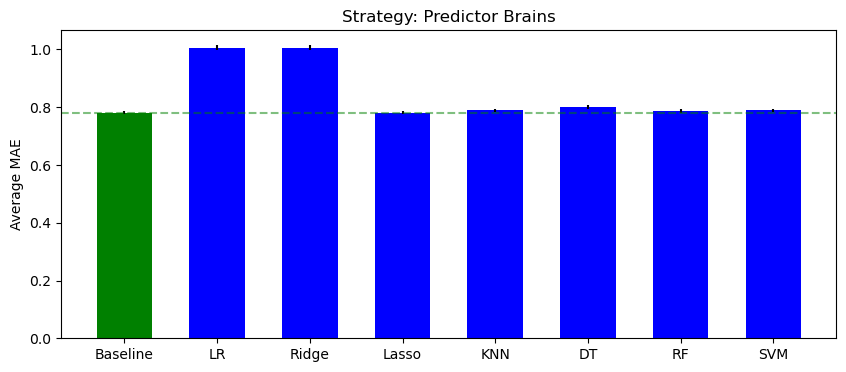

In [43]:
# Retrieve the average MAE and the standard error of the MAE. 
mae = [df_summary_lr_pb['mae_baseline'].mean(), 
       df_summary_lr_pb['mae_model'].mean(), 
       df_summary_ridge_pb['mae_model'].mean(), 
       df_summary_lasso_pb['mae_model'].mean(), 
       df_summary_knn_pb['mae_model'].mean(), 
       df_summary_dt_pb['mae_model'].mean(), 
       df_summary_rf_pb['mae_model'].mean(), 
       df_summary_svm_pb['mae_model'].mean()]
mae_se = [np.std(df_summary_lr_pb['mae_baseline']) / np.sqrt(df_summary_lr_pb['mae_baseline'].shape[0]), 
          np.std(df_summary_lr_pb['mae_model']) / np.sqrt(df_summary_lr_pb['mae_model'].shape[0]), 
          np.std(df_summary_ridge_pb['mae_model']) / np.sqrt(df_summary_ridge_pb['mae_model'].shape[0]), 
          np.std(df_summary_lasso_pb['mae_model']) / np.sqrt(df_summary_lasso_pb['mae_model'].shape[0]), 
          np.std(df_summary_knn_pb['mae_model']) / np.sqrt(df_summary_knn_pb['mae_model'].shape[0]), 
          np.std(df_summary_dt_pb['mae_model']) / np.sqrt(df_summary_dt_pb['mae_model'].shape[0]), 
          np.std(df_summary_rf_pb['mae_model']) / np.sqrt(df_summary_rf_pb['mae_model'].shape[0]), 
          np.std(df_summary_svm_pb['mae_model']) / np.sqrt(df_summary_svm_pb['mae_model'].shape[0])]

# Display the average MAE and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4))
axes.bar(range(8), mae, width = 0.6, color = ['green', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'])
axes.errorbar(range(8), mae, yerr = mae_se, fmt = 'None', color = 'black')
axes.axhline(mae[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(8), labels = ['Baseline', 'LR', 'Ridge', 'Lasso', 'KNN', 'DT', 'RF', 'SVM'])
axes.set_ylabel('Average MAE')
axes.set_title('Strategy: Predictor Brains');

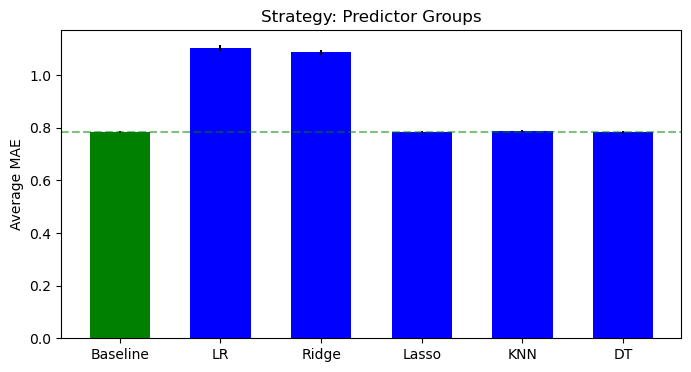

In [44]:
# Retrieve the average MAE and the standard error of the MAE. 
mae = [df_summary_lr_pg['mae_baseline'].mean(), 
       df_summary_lr_pg['mae_model'].mean(), 
       df_summary_ridge_pg['mae_model'].mean(), 
       df_summary_lasso_pg['mae_model'].mean(), 
       df_summary_knn_pg['mae_model'].mean(), 
       df_summary_dt_pg['mae_model'].mean()]
mae_se = [np.std(df_summary_lr_pg['mae_baseline']) / np.sqrt(df_summary_lr_pg['mae_baseline'].shape[0]), 
          np.std(df_summary_lr_pg['mae_model']) / np.sqrt(df_summary_lr_pg['mae_model'].shape[0]), 
          np.std(df_summary_ridge_pg['mae_model']) / np.sqrt(df_summary_ridge_pg['mae_model'].shape[0]), 
          np.std(df_summary_lasso_pg['mae_model']) / np.sqrt(df_summary_lasso_pg['mae_model'].shape[0]), 
          np.std(df_summary_knn_pg['mae_model']) / np.sqrt(df_summary_knn_pg['mae_model'].shape[0]), 
          np.std(df_summary_dt_pg['mae_model']) / np.sqrt(df_summary_dt_pg['mae_model'].shape[0])]

# Display the average MAE and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))
axes.bar(range(6), mae, width = 0.6, color = ['green', 'blue', 'blue', 'blue', 'blue', 'blue'])
axes.errorbar(range(6), mae, yerr = mae_se, fmt = 'None', color = 'black')
axes.axhline(mae[0], 0, 6, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(6), labels = ['Baseline', 'LR', 'Ridge', 'Lasso', 'KNN', 'DT'])
axes.set_ylabel('Average MAE')
axes.set_title('Strategy: Predictor Groups');

In [45]:
# Save the features into Pickle files. 
with open(preprocessed_data_path + 'features/dict_features_basis.p', 'wb') as file:
    pickle.dump(dict_features_basis, file)
with open(preprocessed_data_path + 'features/dict_features_sequence.p', 'wb') as file:
    pickle.dump(dict_features_sequence, file)
    
# Save the targets into Pickle files. 
with open(preprocessed_data_path + 'targets/dict_targets_basis.p', 'wb') as file:
    pickle.dump(dict_targets_basis, file)
with open(preprocessed_data_path + 'targets/dict_targets_sequence.p', 'wb') as file:
    pickle.dump(dict_targets_sequence, file)

# Save the baselines into Pickle files. 
with open(preprocessed_data_path + 'baseline/dict_baseline_basis.p', 'wb') as file:
    pickle.dump(dict_baseline_basis, file)
with open(preprocessed_data_path + 'baseline/dict_baseline_sequence.p', 'wb') as file:
    pickle.dump(dict_baseline_sequence, file)

# Save the models into Pickle files. 
with open(results_path + 'dict_models_lr_pb.p', 'wb') as file:
    pickle.dump(dict_models_lr_pb, file)
with open(results_path + 'dict_models_lr_pg.p', 'wb') as file:
    pickle.dump(dict_models_lr_pg, file)
with open(results_path + 'dict_models_ridge_pb.p', 'wb') as file:
    pickle.dump(dict_models_ridge_pb, file)
with open(results_path + 'dict_models_ridge_pg.p', 'wb') as file:
    pickle.dump(dict_models_ridge_pg, file)
with open(results_path + 'dict_models_lasso_pb.p', 'wb') as file:
    pickle.dump(dict_models_lasso_pb, file)
with open(results_path + 'dict_models_lasso_pg.p', 'wb') as file:
    pickle.dump(dict_models_lasso_pg, file)
with open(results_path + 'dict_models_knn_pb.p', 'wb') as file:
    pickle.dump(dict_models_knn_pb, file)
with open(results_path + 'dict_models_knn_pg.p', 'wb') as file:
    pickle.dump(dict_models_knn_pg, file)
with open(results_path + 'dict_models_dt_pb.p', 'wb') as file:
    pickle.dump(dict_models_dt_pb, file)
with open(results_path + 'dict_models_dt_pg.p', 'wb') as file:
    pickle.dump(dict_models_dt_pg, file)
with open(results_path + 'dict_models_rf_pb.p', 'wb') as file:
    pickle.dump(dict_models_rf_pb, file)
with open(results_path + 'dict_models_svm_pb.p', 'wb') as file:
    pickle.dump(dict_models_svm_pb, file)